In [2]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir('../notebook_format')
from formats import load_style
load_style()

In [60]:
os.chdir(path)
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6 # change default figure size

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
%load_ext watermark
%load_ext autoreload 
%autoreload 2

# pip install hdbscan
from hdbscan import HDBSCAN
from sklearn.datasets import make_blobs, make_moons

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,scikit-learn,hdbscan,seaborn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Ethen 2016-08-02 13:58:14 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
scikit-learn 0.17.1
hdbscan 0.8
seaborn 0.7.1


# Clustering

Clustering is all about finding groups of data that are all "similar". The idea is simple, but the hard part is to define the notion of similarity, which is key to determine whether the clustering algorithm is good or not.

Say, we have some data like below, and we want to cluster it. How exactly do we do that, and what do the results look like?

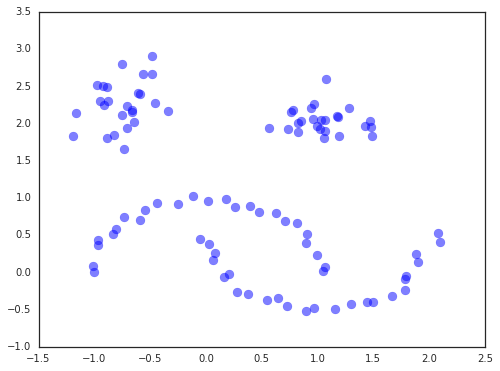

In [46]:
# stack two randomly generated datasets together
moons, _ = make_moons( n_samples = 50, noise = 0.05)
blobs, _ = make_blobs( n_samples = 50, centers = [(-0.75,2.25), (1.0, 2.0)], cluster_std = 0.25 )
data = np.vstack([ moons, blobs ])

sns.set_style('white')
plot_kwds = { 'alpha' : 0.5, 's' : 80 }
plt.scatter( x = data.T[0], y = data.T[1], color = 'b', **plot_kwds )
plt.show()

`HDBSCAN`, Hierarchical Density-Based Spatial Clustering of Applications with Noise, is an unsupervised learning algorithm that's used to find clusters, or dense regions of a dataset. To perform the clustering, we need to generate a clustering object `HDBSCAN` and call `.fit(data)` to the data we have. 

In [63]:
clusterer = HDBSCAN( gen_min_span_tree = True )
clusterer.fit(data)

HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=True, leaf_size=40, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)

The clusterer object stores the clustering result in an attribute `labels_`, which is an array of integers for each data point. Data points that are in the same cluster get assigned the same number. The cluster labels starts from 0 and goes up to the total number of clusters found by the algorithm. We can thus determine the number of clusters found by checking what the largest cluster label is.

In [52]:
print( 'labels:', clusterer.labels_ )
n_cluster = clusterer.labels_.max() + 1
print( 'cluster number:', n_cluster )

labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 1 2 2 2 2 1 1 2 1 2 2 1 1 1 1 1 2 2 1 2 1
 2 2 1 2 2 2 1 1 1 1 1 2 1 1 1 2 2 1 2 2 2 2 2 1 2 1]
cluster number: 3


So we have a total of three clusters, with labels 0, 1, and 2. 

`HDBSCAN` has two important feautures:

- It is noise aware. Real data are filled with noise, not every point should belong in a cluster. `HDBSCAN` address this by assigning these data points the label -1.
- `HDBSCAN` implements soft clustering, where wach data point is assigned a cluster membership score ranging from 0.0 to 1.0. A score of 0.0 represents a sample that is not in the cluster at all (all noise points will get this score). We can access these scores via the `probabilities_` attribute.

In [53]:
clusterer.probabilities_

array([ 1.        ,  0.96056542,  1.        ,  1.        ,  1.        ,
        1.        ,  0.74804033,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  0.84796051,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        0.86769402,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  0.97618963,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  0.91744351,  1.        ,
        0.92984725,  1.        ,  1.        ,  0.6684288 ,  0.85819768,
        0.9665954 ,  0.66978082,  0.9678169 ,  0.62428636,  0.71533093,
        0.83337595,  1.        ,  0.79783528,  0.87034939,  0.28703874,
        0.48312873,  0.5753462 ,  0.60169301,  0.68688336,  0.72

Since this is simply the 2d dataset, we can easily visualize the clustering labels with different colors (and even the cluster membership strengths as levels of saturation)

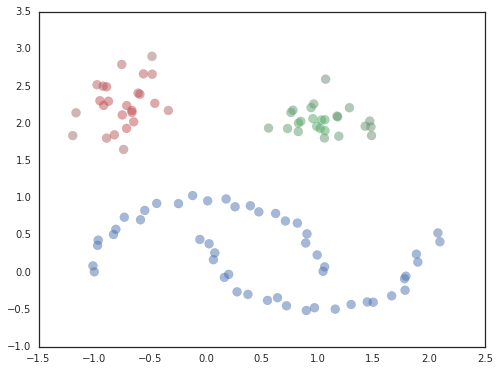

In [54]:
# assign colors to each data point
# the ones with higher probability will have darker color
color_palette = sns.color_palette( 'deep', n_cluster )
cluster_colors = [ color_palette[x] if x >= 0
                   else (0.5, 0.5, 0.5)
                   for x in clusterer.labels_ ]
cluster_member_colors = [ sns.desaturate( x, p ) for x, p in
                          zip(cluster_colors, clusterer.probabilities_) ]
plt.scatter( x = data[:, 0], y = data[:, 1], 
             color = cluster_member_colors, **plot_kwds )
plt.show()

## How Does it Work



In [59]:
clusterer.minimum_spanning_tree_

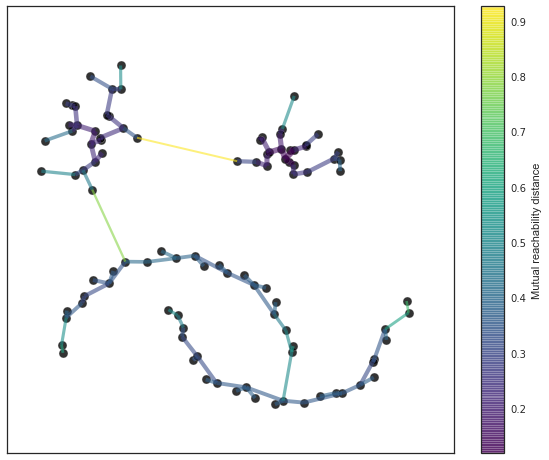

In [65]:
plt.figure( figsize = ( 10, 8 ) )
clusterer.minimum_spanning_tree_.plot( edge_cmap = 'viridis',
                                       edge_alpha = 0.6,
                                       node_size = 80,
                                       edge_linewidth = 2 )
plt.show()

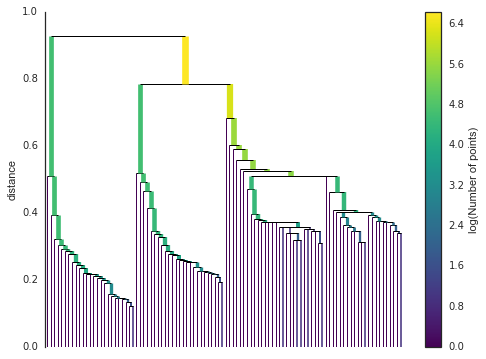

In [66]:
clusterer.single_linkage_tree_.plot(cmap = 'viridis', colorbar = True)
plt.show()

In [71]:
HDBSCAN( min_cluster_size, min_samples )

Distsance Metrics and Parameters



DBSCAN, clusters are dense areas separated by less dense areas. It draws balls of a given radius for each data point and if that ball has more than K (hyperparameter to the algorithm) other data points within it, then it'll called the original data point dense.

During the process above, remember that the radius size is fixed. Now, we can flip this idea around and say we're going to draw a circle of whatever radius we need to, to enclose K data points. Again, the smaller the radius size needed, the denser the point.

The connected components of the level sets forms a tree. 

We don't want to run connected components for every possible radius. Minimum spanning tree.


You should think hard about what you mean by a good cluster, before doing it. Because it can heavily influence the definition of the "good" cluster.


Locally approximate the density rather than computing it everywhere.

Kmeans shouldn't be your first choice when it comes to clustering.

Kmeans tries to find clusters by minimizing the intra-cluster distance. 

It assumes that all of your clusters are ball-shaped instead of anything else. The other pesky thing about it is that you need to know how many clusters there are before runnning the algorithm

---

Agglomerative clustering builds up a heirarchy and after building it you can specify the height to cut it.

## Reference

- [Youtube: SciPy 2016 High Quality, High Performance Clustering with HDBSCAN](https://www.youtube.com/watch?v=AgPQ76RIi6A&list=PLYx7XA2nY5Gf37zYZMw6OqGFRPjB1jCy6&index=10)
- [HDBSCAN documentation](http://hdbscan.readthedocs.io/en/latest/)